# Hands-On Machine Learning Project
## Topic 20: Credit Data
### Florian Korn, Vincent Bläske, Dennis Götz

## V. Shortlist Promising Models
1. Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, kNN, SVM, random forest, neural net, etc.) using standard parameters.
2. Measure and compare their performance:<br>
◦ For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm (e.g., the features with the largest coefficients in a linear regression model).
4. Analyze the types of errors the models make: What data would a human have used to avoid these errors?
5. Perform a quick round of feature selection and engineering.
6. Perform one or two more quick iterations of the five previous steps.
7. Shortlist the top three to five most promising models, preferring models that make different types of errors.

In [76]:
# Import libraries
import pandas as pd
from pandas import get_dummies
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Attributes
attributes = ['Status of existing checking account', 'Duration in month', 'Credit history', 'Purpose', 'Credit amount', 
           'Savings account/bonds', 'Present employment since', 'Installment rate in percentage of disposable income', 
           'Personal status and sex', 'Other debtors / guarantors', 'Present residence since', 'Property',
           'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank', 'Job',
           'Number of people being liable to provide maintenance for', 'Telephone', 'foreign worker', 'Credit rating']

# Load original dataset DATA-Format
data = pd.read_csv('german.data', sep=' ', header=None)
data.columns = attributes

# Load numerical dataset CSV-Format
data_num = pd.read_csv('german.data-numeric.csv', sep=';', header=None)

# Qualitative attributes
cat_attribs = ['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds', 
                'Present employment since', 'Personal status and sex', 'Other debtors / guarantors', 'Property',
                'Other installment plans', 'Housing', 'Job', 'Telephone', 'foreign worker', 'Credit rating']

# Numerical attributes
num_attribs = list(set(attributes) - set(cat_attribs))

# Copy the data to a new DataFrame
data_values = data.copy()

# Create dictionary with real values to make the DataFrame readable
cat_dict = {# Attribute 1: (qualitative) Status of existing checking account 
                    'A11' : '... < 0 DM',
                    'A12' : '0 <= ... < 200 DM',
                    'A13' : '... >= 200 DM / salary assignments for at least 1 year',
                    'A14' : 'no checking account',

                    # Attribute 3: (qualitative) Credit history 
                    'A30' : 'no credits taken/ all credits paid back duly',
                    'A31' : 'all credits at this bank paid back duly',
                    'A32' : 'existing credits paid back duly till now',
                    'A33' : 'delay in paying off in the past',
                    'A34' : 'critical account/ other credits existing (not at this bank)',
                    
                    # Attribute 4: (qualitative) Purpose 
                    'A40' : 'car (new)',
                    'A41' : 'car (used)',
                    'A42' : 'furniture/equipment',
                    'A43' : 'radio/television',
                    'A44' : 'domestic appliances',
                    'A45' : 'repairs',
                    'A46' : 'education',
                    'A47' : '(vacation - does not exist?)',
                    'A48' : 'retraining',
                    'A49' : 'business',
                    'A410' : 'others',

                    # Attibute 6: (qualitative) Savings account/bonds 
                    'A61' : '... < 100 DM',
                    'A62' : '100 <= ... < 500 DM',
                    'A63' : '500 <= ... < 1000 DM',
                    'A64' : '... >= 1000 DM',
                    'A65' : 'unknown/ no savings account',

                    # Attribute 7: (qualitative) Present employment since 
                    'A71' : 'unemployed',
                    'A72' : '... < 1 year',
                    'A73' : '1 <= ... < 4 years',
                    'A74' : '4 <= ... < 7 years',
                    'A75' : '... >= 7 years',

                    # Attribute 9: (qualitative) Personal status and sex 
                    'A91' : 'male : divorced/separated',
                    'A92' : 'female : divorced/separated/married',
                    'A93' : 'male : single',
                    'A94' : 'male : married/widowed',
                    'A95' : 'female : single',

                    # Attribute 10: (qualitative) Other debtors / guarantors 
                    'A101' : 'none',
                    'A102' : 'co-applicant',
                    'A103' : 'guarantor',

                    # Attribute 12: (qualitative) Property 
                    'A121' : 'real estate',
                    'A122' : 'if not A121 : building society savings agreement/ life insurance',
                    'A123' : 'if not A121/A122 : car or other, not in attribute 6',
                    'A124' : 'unknown / no property',

                    # Attribute 14: (qualitative) Other installment plans 
                    'A141' : 'bank',
                    'A142' : 'stores',
                    'A143' : 'none',

                    # Attribute 15: (qualitative) Housing 
                    'A151' : 'rent',
                    'A152' : 'own',
                    'A153' : 'for free',

                    # Attribute 17: (qualitative) Job
                    'A171' : 'unemployed/ unskilled - non-resident',
                    'A172' : 'unskilled - resident',
                    'A173' : 'skilled employee / official',
                    'A174' : 'management/ self-employed/ highly qualified employee/ officer',

                    # Attribute 19: (qualitative) Telephone
                    'A191' : 'none',
                    'A192' : 'yes, registered under the customers name',

                    # Attribute 20: (qualitative) foreign worker 
                    'A201' : 'yes',
                    'A202' : 'no',

                    # Target value: (qualitative) Credit rating
                    1 : 'good',
                    2 : 'bad'
                    }

# Apply the dictionary to all categorical attributes of the new DataFrame to get the real values
data_values[cat_attribs] = pd.DataFrame([data_values[attribute].apply(lambda key: cat_dict[key]) for attribute in cat_attribs]).T

In [77]:
attributes = ['Status of existing checking account', 'Duration in month', 'Credit history', 'Purpose', 'Credit amount', 
           'Savings account/bonds', 'Present employment since', 'Installment rate in percentage of disposable income', 
           'Other debtors / guarantors', 'Present residence since', 'Property',
           'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank', 'Job',
           'Number of people being liable to provide maintenance for', 'Telephone', 'Credit rating']
cat_attribs = ['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds', 
                'Present employment since', 'Other debtors / guarantors', 'Property',
                'Other installment plans', 'Housing', 'Job', 'Telephone']

In [78]:
# Create a Test Set
data_values_feature_selection = data_values.drop(['Personal status and sex', 'foreign worker'], axis = 1)

onehot_encoder = OneHotEncoder()
data_cat_1hot = onehot_encoder.fit_transform(data_values_feature_selection[cat_attribs])
data_cat_dummies = pd.DataFrame(data_cat_1hot.toarray(),
                                columns=onehot_encoder.get_feature_names_out(), #generate new column names with category as suffix to the attribute
                                index=data_values_feature_selection.index) #keep old indices
data_num = data_values_feature_selection[data_values_feature_selection.columns.difference(cat_attribs)]
data_num = data_num.drop(['Credit rating'], axis = 1)

ordinal_encoder = OrdinalEncoder()
data_y = pd.DataFrame(ordinal_encoder.fit_transform(pd.DataFrame(data_values_feature_selection.iloc[:, -1])).astype(int))
data_y.columns = ['Credit rating']

data_values_encoded = pd.concat([data_num, data_cat_dummies, data_y], axis = 1)

train_set, test_set = train_test_split(data_values_encoded, train_size=0.8, random_state=0, stratify=data_values['Credit rating'])

# Separate features and target values in train and test set
X_train = np.array(train_set.iloc[:, :-1])
y_train = np.array(train_set.iloc[:, -1])
X_test = np.array(test_set.iloc[:, :-1])
y_test = np.array(test_set.iloc[:, -1])

print(f'{X_train.shape = }')
print(f'{X_test.shape = }\n')

X_train.shape = (800, 55)
X_test.shape = (200, 55)



# **Train models with standard parameters**

In [79]:
# Create Pipelines

# Linear Models
## Linear Regression
pipe_reg = Pipeline([('reg', LinearRegression())])

## Ridge Regression
pipe_ridgereg = Pipeline([('scaler', StandardScaler()),
                          ('ridgereg', linear_model.Ridge())])

## Lasso Regression
pipe_lassoreg = Pipeline([('scaler', StandardScaler()),
                          ('lassoreg', linear_model.Lasso())])

## Logistic Regression
pipe_logreg = Pipeline([('scaler', StandardScaler()),
                        ('logreg', LogisticRegression())])

# kNN
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

# naiveBayes
pipe_gaussiannb = Pipeline([('gaussiannb', GaussianNB())])

# Support Vector Machine
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm.SVC())])

# Random Forest
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

# Extra Trees Classifier
pipe_extratrees = Pipeline([('scaler', StandardScaler()),
                            ('extratrees', ExtraTreesClassifier())])

# Gradient Boosting Classifier
pipe_gradientboost = Pipeline([('scaler', StandardScaler()),
                               ('gradientboost', GradientBoostingClassifier())])

# AdaBoost Classifier
pipe_adaboost = Pipeline([('scaler', StandardScaler()),
                          ('adaboost', AdaBoostClassifier())])

# SGD Classifier
pipe_sgd = Pipeline([('scaler', StandardScaler()),
                     ('sgd', SGDClassifier())])


# Decision Tree
pipe_decisiontree = Pipeline([('decisiontree', tree.DecisionTreeClassifier())])

# Neural Network Classifier
pipe_neuralnetwork = Pipeline([('scaler', StandardScaler()),
                               ('neuralnetwork', MLPClassifier())])

# K Fold iterator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# List of pipelines
pipeline_list = [pipe_reg,
                 pipe_ridgereg,
                 pipe_lassoreg,
                 pipe_logreg,
                 pipe_knn,
                 pipe_gaussiannb,
                 pipe_svm,
                 pipe_rf,
                 pipe_extratrees,
                 pipe_gradientboost,
                 pipe_adaboost,
                 pipe_sgd,
                 pipe_decisiontree,
                 pipe_neuralnetwork]

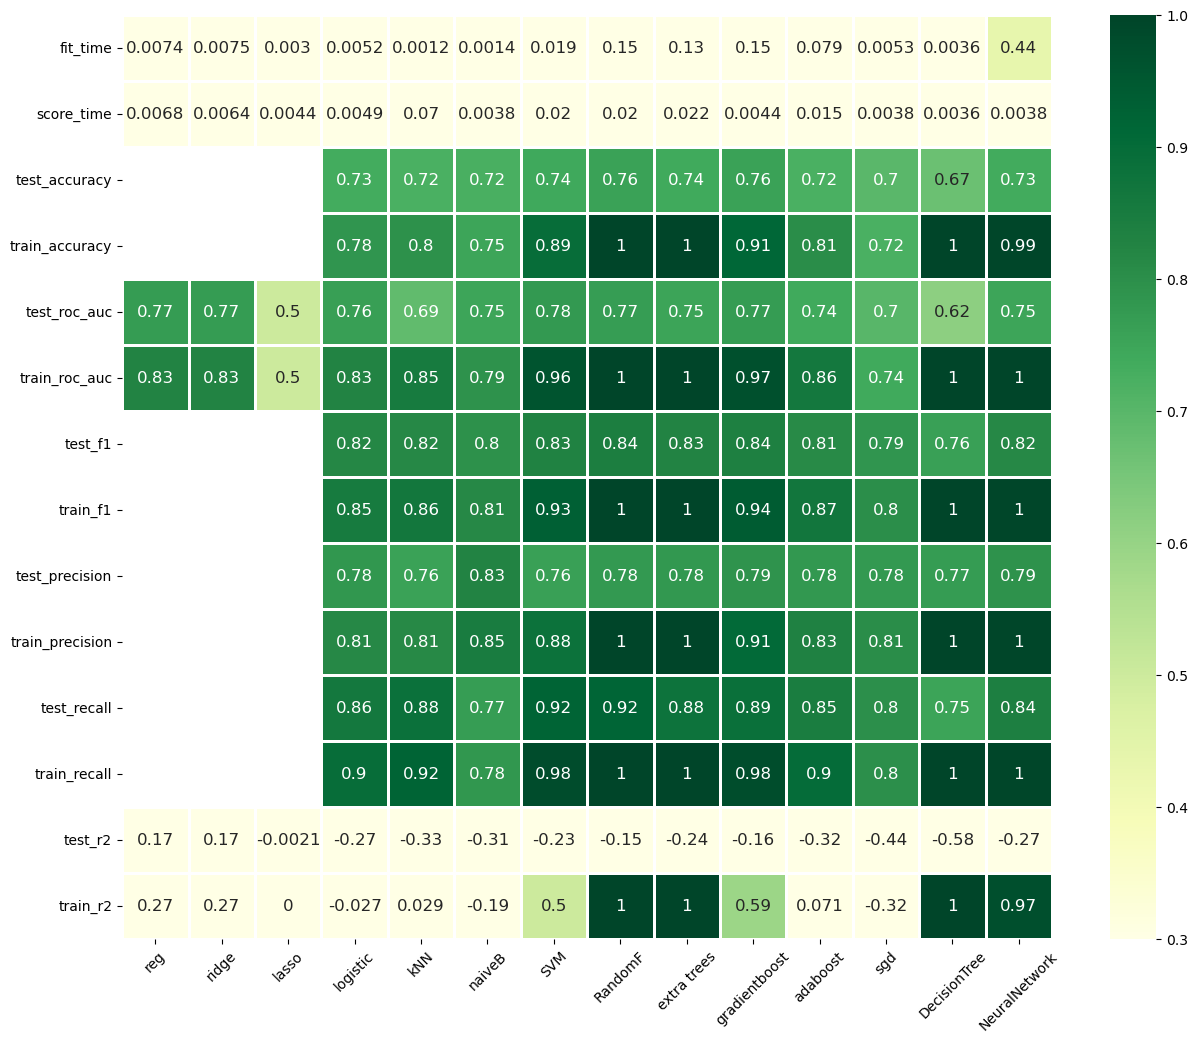

In [113]:
# compute scores of quick and dirty models
scores = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                            X_train,
                                                            y_train,
                                                            scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                            cv=kfold,
                                                            n_jobs=-1,
                                                            return_train_score=True)).mean(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
scores.columns = ['reg', 'ridge', 'lasso', 'logistic', 'kNN', 'naiveB', 'SVM', 'RandomF','extra trees', 'gradientboost', 'adaboost','sgd', 'DecisionTree', 'NeuralNetwork']

# Visualize scores
plt.figure(figsize=(15, 12))  # Adjust the figure size as needed
sns.heatmap(scores, vmin=0.3, vmax=1, center=0.65, linewidths=1, linecolor='white', cmap='YlGn',
            annot=True, annot_kws={"size": 12})  # Increase the font size of the annotations
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.show()


In [114]:
import re

# Filter rows using regex of test_
test_scores = scores[scores.index.str.contains(r'^test_')]
test_scores = test_scores.drop("test_r2", axis=0)

test_scores = test_scores.T

# compute mean of the test scores
test_scores['mean_test_score'] = test_scores.mean(axis=1)
test_scores


,test_accuracy,test_roc_auc,test_f1,test_precision,test_recall,mean_test_score
reg,NaN,0.770931,NaN,NaN,NaN,0.770931
ridge,NaN,0.771188,NaN,NaN,NaN,0.771188
lasso,NaN,0.500000,NaN,NaN,NaN,0.500000
logistic,0.73375,0.762749,0.818917,0.781374,0.860769,0.791512
kNN,0.72125,0.687205,0.815770,0.758973,0.882978,0.773235
naiveB,0.72500,0.750215,0.796184,0.827088,0.768297,0.773357
SVM,0.74125,0.777601,0.832828,0.760174,0.921810,0.806733
RandomF,0.75875,0.768634,0.842111,0.777069,0.919857,0.813284
extra trees,0.74000,0.751913,0.825489,0.778765,0.879079,0.795049
gradientboost,0.75750,0.772093,0.836544,0.791511,0.887467,0.809023


We trained multiple models within and across different categories, without tuning the hyperparameters to get a quick overview which models we should follow up on further. 

Amongst the ensemble methods, we decided for the random Forest, as it performs well on every evaluation metric tested, resulting in a higher mean in the performance metrics compared to the other ensemble methods tested. Most importantly, it has a good balance between precission and recall, which indicates that the model is capable of minimizing misclassification.

Next we wanted to look further into te logistic regression as it performs well over all metric scores test. Additionaly it provides a very interpretable results, which can help to understand the results of the classification. Another advantage would be the computationally efficiency, as it has a limited number of hyperparameters to train.



# 1. RandomForest

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Random Forest
#pipe_rf = Pipeline([('rf', RandomForestClassifier())])

rf_param_space = {
    'rf__n_estimators': randint(100, 1000), # [100, 200,300,400,500]
    'rf__max_depth':  randint(1, 20) ,      # [None, 5, 10, 20]
    'rf__min_samples_split':randint(2, 20),  # [2, 5, 10]
    'rf__min_samples_leaf': randint(1, 8),   # [1, 2, 4],
    'rf__max_features': randint(3, 15),    # ['auto', 'sqrt'] 
    'rf__max_leaf_nodes': randint(3, 15)  #[None, 5, 10, 20]
}

#rf_grid_search = GridSearchCV(pipe_rf, rf_param_grid, cv=kfold, scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'], refit='roc_auc', n_jobs=-1)
rf_random_search = RandomizedSearchCV(pipe_rf, rf_param_space, cv=kfold, n_iter=300,  scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'], refit='roc_auc', n_jobs=-1,  random_state=0)
                                                      
rf_random_search.fit(X_train, y_train)

rf_cv_results = pd.DataFrame(rf_random_search.cv_results_)



In [118]:
# filter out the relevant columns
rf_columns = ['mean_fit_time', 'param_rf__max_depth', 'param_rf__min_samples_leaf', 'param_rf__min_samples_split',
                   'param_rf__n_estimators',  'mean_test_accuracy', 'mean_test_roc_auc', 'mean_test_f1',
                   'mean_test_precision', 'mean_test_recall', 'mean_test_r2']

rf_filtered_results = rf_cv_results.loc[:, rf_columns]

# filter out the rows with the best metrics
highest_accuracy = filtered_results.loc[filtered_results['mean_test_accuracy'].idxmax()]
highest_roc_auc = filtered_results.loc[filtered_results['mean_test_roc_auc'].idxmax()]
highest_f1 = filtered_results.loc[filtered_results['mean_test_f1'].idxmax()]
highest_precision = filtered_results.loc[filtered_results['mean_test_precision'].idxmax()]
highest_recall = filtered_results.loc[filtered_results['mean_test_recall'].idxmax()]
highest_r2 = filtered_results.loc[filtered_results['mean_test_r2'].idxmax()]


rf_highest_scores = pd.concat([highest_accuracy, highest_roc_auc, highest_f1, highest_precision, highest_recall, highest_r2], axis=1).T
rf_highest_scores.index = ['highest_accuracy', 'highest_roc_auc', 'highest_f1', 'highest_precision', 'highest_recall', 'highest_r2']


# Scores on quick-and-dirty models: 0.74 0.77 0.83 0.76 0.9
rf_highest_scores

,mean_fit_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_accuracy,mean_test_roc_auc,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_r2
highest_accuracy,0.534687,14,2,3,258,0.75625,0.763764,0.840477,0.775631,0.917827,-0.161358
highest_roc_auc,1.175063,13,1,14,626,0.74875,0.769048,0.83748,0.76555,0.925036,-0.196678
highest_f1,1.639166,12,1,14,911,0.755,0.768325,0.841733,0.768923,0.930365,-0.167359
highest_precision,0.534687,14,2,3,258,0.75625,0.763764,0.840477,0.775631,0.917827,-0.161358
highest_recall,0.420029,2,3,5,312,0.7,0.757765,0.823415,0.7,1.0,-0.42939
highest_r2,0.534687,14,2,3,258,0.75625,0.763764,0.840477,0.775631,0.917827,-0.161358


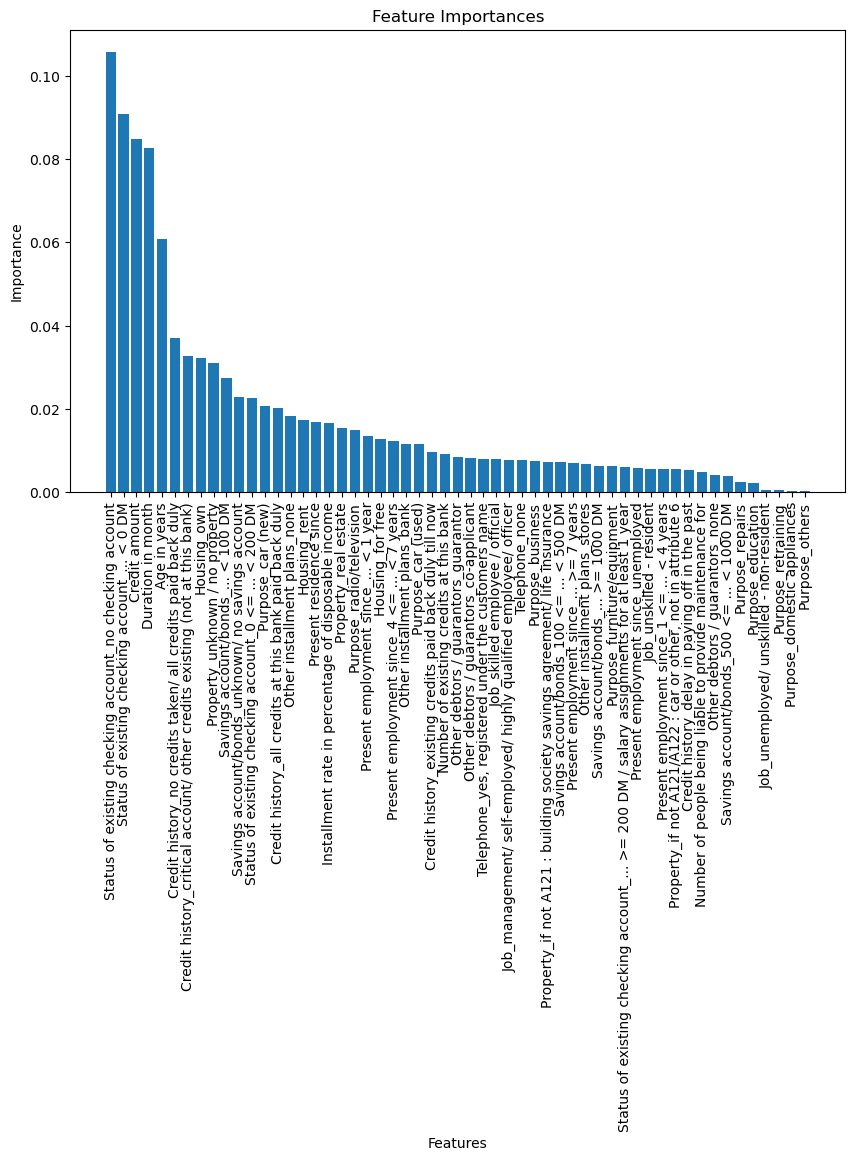

In [146]:
best_estimator = rf_random_search.best_estimator_
feature_importances = best_estimator['rf'].feature_importances_

# Get the names of the features
feature_names = list(data_values_encoded.columns[:-1])  

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange the feature names based on the sorted indices
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation= 90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()